**1D-CNN experiments with average dataset (dat_files)**

Classifying fear vs anger with a 1D-CNN model that has been fine-tuned. Experiments are also run with the raw data and the data after it has been scaled.

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Change directory to that with dataset

In [ ]:
%cd drive/My\ Drive/dat_files

**Files are of the format FM#_XY**

**Where # is participant number, X=1 for fear or 2 for anger, and Y=1 for dynamic or 2 for static**

**Imports**

In [ ]:
import glob
from os.path import splitext
import os
import numpy as np
from matplotlib import pyplot as plt   
import tensorflow as tf
import pandas as pd
import sklearn.linear_model
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler, Normalizer

**Grab csv files and apply labels (0 for fear, 1 for anger)**

In [ ]:
static_files = np.array([])
static_labels = np.array([], dtype=int)
static_groups = np.array([], dtype=int)
#get all static files
for file in glob.iglob("*2.csv"):
  static_files = np.append(static_files, file)
  static_groups = np.append(static_groups, file[2:4])
  if file[5] == '1':
    static_labels = np.append(static_labels, 0)
  else:
    static_labels = np.append(static_labels, 1)

In [ ]:
dyn_files = np.array([])
dyn_labels = np.array([], dtype=int)
dyn_groups = np.array([], dtype=int)
#get all dynamic files
for file in glob.iglob("*1.csv"):
  dyn_files = np.append(dyn_files, file)
  dyn_groups = np.append(dyn_groups, file[2:4])
  if file[5] == '1':
    dyn_labels = np.append(dyn_labels, 0)
  else:
    dyn_labels = np.append(dyn_labels, 1)

**Get raw data from csv files and clean up channel names (remove whitespace)**

In [ ]:
#list to hold dataframes
static_dfs = []
#rows to skip
skip_rows = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19])

#read in static csvs as pandas df
for x in range(0, static_files.size):
  df = pd.read_csv(static_files[x], sep='\t', skiprows=skip_rows, header=(0))
  #remove whitespace from channel names
  for y in range(0, len(df.columns)):
    ch_name = df.iloc[0:,y].name
    #remove whitespace
    new_name = ''.join(ch_name.split())
    #rename column
    df.rename(columns={ch_name: new_name}, inplace=True)

  #append df to list  
  static_dfs.append(df)

#convert list to np array
static_dfs = np.asarray(static_dfs)

In [ ]:
#list to hold dataframes
dyn_dfs = []
#rows to skip
skip_rows = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19])

#read in static csvs as pandas df
for x in range(0, dyn_files.size):
  df = pd.read_csv(dyn_files[x], sep='\t', skiprows=skip_rows, header=(0))
  #remove whitespace from channel names
  for y in range(0, len(df.columns)):
    ch_name = df.iloc[0:,y].name
    #remove whitespace
    new_name = ''.join(ch_name.split())
    #rename column
    df.rename(columns={ch_name: new_name}, inplace=True)
  
  #append df to list  
  dyn_dfs.append(df)

#convert list to np array
dyn_dfs = np.asarray(dyn_dfs)

**Drop unneeded channels**

In [ ]:
for x in range(0, static_dfs.size):
  if "[HEO]" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["[HEO]"], inplace=True)
  if "[VEO]" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["[VEO]"], inplace=True)
  if "Unnamed:65" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["Unnamed:65"], inplace=True)
  if "Unnamed:66" in static_dfs[x].columns:
    static_dfs[x].drop(columns=["Unnamed:66"], inplace=True)

In [ ]:
for x in range(0, dyn_dfs.size):
  if "Unnamed:65" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["Unnamed:65"], inplace=True)
  if "[HEO]" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["[HEO]"], inplace=True)
  if "[VEO]" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["[VEO]"], inplace=True)
  if "Unnamed:66" in dyn_dfs[x].columns:
    dyn_dfs[x].drop(columns=["Unnamed:66"], inplace=True)

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    diff = cm.max() - cm.min()
    thresh = cm.min() + (diff/2.)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='xx-large',
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #save figure
    plt.savefig('figures/' + title + '.pdf')

**Convert DFs to 3D NumPy array (samples, rows, cols)**

In [ ]:
static_nps = []

for x in range(0, static_dfs.size):
  static_nps.append(static_dfs[x].to_numpy())

#convert to numpy array
static_nps = np.asarray(static_nps)

In [ ]:
dyn_nps = []

for x in range(0, dyn_dfs.size):
  dyn_nps.append(dyn_dfs[x].to_numpy())

#convert to numpy array
dyn_nps = np.asarray(dyn_nps)

**Create CNN Model**

In [ ]:
def create_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64

  model = Sequential()
  #add 2 1D Convolution Layers
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ROWS, COLS)))
  #downsample input representation
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(filters=64, kernel_size=5, activation='relu')) 
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())
  #Add two dense layers
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

  return model

**Helper / plotting functions**

In [ ]:
#helper function for plotting graphs of our results
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

**Group K fold validation**

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 7s - loss: 2.5171 - accuracy: 0.3889 - val_loss: 0.8496 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.7807 - accuracy: 0.5000 - val_loss: 0.7984 - val_accuracy: 0.4000
Epoch 3/25
 - 0s - loss: 0.7390 - accuracy: 0.5556 - val_loss: 0.7879 - val_accuracy: 0.4000
Epoch 4/25
 - 0s - loss: 0.6370 - accuracy: 0.7222 - val_loss: 0.7754 - val_accuracy: 0.3000
Epoch 5/25
 - 0s - loss: 0.4584 - accuracy: 0.8333 - val_loss: 0.8743 - val_accuracy: 0.4000
Epoch 6/25
 - 0s - loss: 0.3802 - accuracy: 0.8333 - val_loss: 1.5695 - val_accuracy: 0.5000
Epoch 7/25
 - 0s - loss: 0.7992 - accuracy: 0.8333 - val_loss: 1.9043 - val_accuracy: 0.3000
Epoch 8/25
 - 0s - loss: 0.7177 - accuracy: 0.8056 - val_loss: 1.6398 - val_accuracy: 0.5000
Epoch 9/25
 - 0s - loss: 0.4448 - accuracy: 0.8056 - val_loss: 0.8651 - val_accuracy: 0.8000
Epoch 10/25
 - 0s - loss: 0.8550 - accuracy: 0.7222 - val_loss: 0.9559 - val_accuracy: 0.7000
Epoch 11/25
 - 0s - loss:

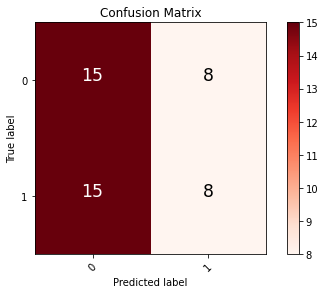

In [ ]:
#static files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []
splits = []
class_names = [0, 1]

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(static_nps, static_labels, static_groups):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_nps[train_index], static_nps[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #print graphs to see best parameter values
  #plot_graphs(history, 'accuracy')
  #plot_graphs(history, 'loss')

  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  splits[x]
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')


Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 0s - loss: 3.9490 - accuracy: 0.3889 - val_loss: 1.3901 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.8449 - accuracy: 0.4722 - val_loss: 1.0264 - val_accuracy: 0.4000
Epoch 3/25
 - 0s - loss: 0.8784 - accuracy: 0.5833 - val_loss: 1.5309 - val_accuracy: 0.5000
Epoch 4/25
 - 0s - loss: 0.4871 - accuracy: 0.7222 - val_loss: 1.2123 - val_accuracy: 0.5000
Epoch 5/25
 - 0s - loss: 0.3547 - accuracy: 0.8889 - val_loss: 1.7454 - val_accuracy: 0.5000
Epoch 6/25
 - 0s - loss: 0.3359 - accuracy: 0.9167 - val_loss: 1.2577 - val_accuracy: 0.4000
Epoch 7/25
 - 0s - loss: 0.1229 - accuracy: 0.9722 - val_loss: 2.1808 - val_accuracy: 0.5000
Epoch 8/25
 - 0s - loss: 0.1220 - accuracy: 0.9444 - val_loss: 1.4874 - val_accuracy: 0.5000
Epoch 9/25
 - 0s - loss: 0.1061 - accuracy: 0.9444 - val_loss: 1.4681 - val_accuracy: 0.3000
Epoch 10/25
 - 0s - loss: 0.0241 - accuracy: 1.0000 - val_loss: 2.2452 - val_accuracy: 0.4000
Epoch 11/25
 - 0s - loss:

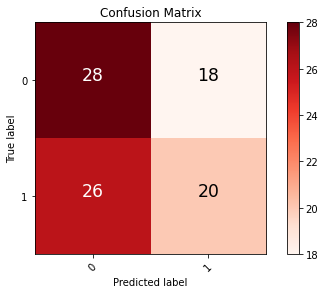

In [ ]:
#dynamic files
n_epochs = 25
n_splits = 5
batch_size = 8
verbose = 2

accuracies = []
losses = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(dyn_nps, dyn_labels, dyn_groups):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_nps[train_index], dyn_nps[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)

  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Scale data**

In [ ]:
# Scale data
for i in range(static_nps.shape[0]):
    scaler = StandardScaler()
    static_nps[i, :, :] = scaler.fit_transform(static_nps[i, :, :]) 

static_nps.shape

(46, 1101, 64)

In [ ]:
# Scale data
for i in range(dyn_nps.shape[0]):
    scaler = StandardScaler()
    dyn_nps[i, :, :] = scaler.fit_transform(dyn_nps[i, :, :]) 

dyn_nps.shape

(46, 1101, 64)

**Group K fold after scaling**

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 0s - loss: 1.4025 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.6729 - accuracy: 0.5833 - val_loss: 0.6865 - val_accuracy: 0.6000
Epoch 3/25
 - 0s - loss: 0.6549 - accuracy: 0.6389 - val_loss: 0.8881 - val_accuracy: 0.5000
Epoch 4/25
 - 0s - loss: 0.7248 - accuracy: 0.5000 - val_loss: 0.7079 - val_accuracy: 0.6000
Epoch 5/25
 - 0s - loss: 0.5437 - accuracy: 0.7778 - val_loss: 0.9013 - val_accuracy: 0.6000
Epoch 6/25
 - 0s - loss: 0.4130 - accuracy: 0.8056 - val_loss: 0.9211 - val_accuracy: 0.5000
Epoch 7/25
 - 0s - loss: 0.4080 - accuracy: 0.8333 - val_loss: 1.2597 - val_accuracy: 0.5000
Epoch 8/25
 - 0s - loss: 0.1317 - accuracy: 0.9167 - val_loss: 2.0144 - val_accuracy: 0.5000
Epoch 9/25
 - 0s - loss: 0.0815 - accuracy: 0.9444 - val_loss: 1.4266 - val_accuracy: 0.5000
Epoch 10/25
 - 0s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.6017 - val_accuracy: 0.4000
Epoch 11/25
 - 0s - loss:

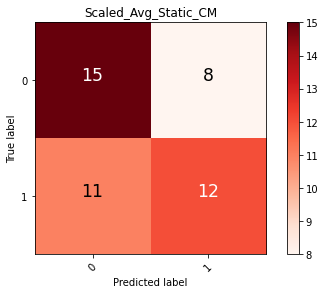

In [ ]:
#static files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []
splits = []
class_names = [0, 1]

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(static_nps, static_labels, static_groups):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_nps[train_index], static_nps[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #print graphs to see best parameter values
  #plot_graphs(history, 'accuracy')
  #plot_graphs(history, 'loss')

  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  splits[x]
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Scaled_Avg_Static_CM')

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 0s - loss: 1.2370 - accuracy: 0.4444 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.6985 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.4000
Epoch 3/25
 - 0s - loss: 0.6310 - accuracy: 0.8056 - val_loss: 0.7068 - val_accuracy: 0.5000
Epoch 4/25
 - 0s - loss: 0.6002 - accuracy: 0.8333 - val_loss: 0.7180 - val_accuracy: 0.4000
Epoch 5/25
 - 0s - loss: 0.4947 - accuracy: 0.9167 - val_loss: 0.7700 - val_accuracy: 0.4000
Epoch 6/25
 - 0s - loss: 0.3109 - accuracy: 0.9722 - val_loss: 0.9273 - val_accuracy: 0.5000
Epoch 7/25
 - 0s - loss: 0.1892 - accuracy: 0.9444 - val_loss: 0.9293 - val_accuracy: 0.3000
Epoch 8/25
 - 0s - loss: 0.0798 - accuracy: 0.9722 - val_loss: 1.6257 - val_accuracy: 0.5000
Epoch 9/25
 - 0s - loss: 0.0718 - accuracy: 0.9722 - val_loss: 1.3358 - val_accuracy: 0.6000
Epoch 10/25
 - 0s - loss: 0.0756 - accuracy: 0.9722 - val_loss: 1.7536 - val_accuracy: 0.6000
Epoch 11/25
 - 0s - loss:

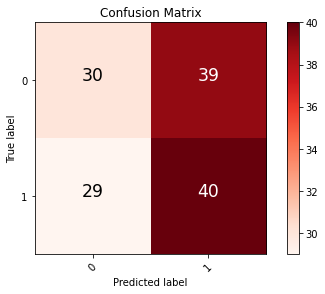

In [ ]:
#dynamic files
n_epochs = 25
n_splits = 5
batch_size = 8
verbose = 2

accuracies = []
losses = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(dyn_nps, dyn_labels, dyn_groups):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_nps[train_index], dyn_nps[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)
  
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**K fold (no groups)**

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 0s - loss: 1.4618 - accuracy: 0.4444 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 2/25
 - 0s - loss: 0.6831 - accuracy: 0.4722 - val_loss: 0.7417 - val_accuracy: 0.4000
Epoch 3/25
 - 0s - loss: 0.7061 - accuracy: 0.5833 - val_loss: 0.8214 - val_accuracy: 0.1000
Epoch 4/25
 - 0s - loss: 0.6654 - accuracy: 0.6389 - val_loss: 0.8364 - val_accuracy: 0.4000
Epoch 5/25
 - 0s - loss: 0.6330 - accuracy: 0.6944 - val_loss: 1.8188 - val_accuracy: 0.4000
Epoch 6/25
 - 0s - loss: 0.5449 - accuracy: 0.7500 - val_loss: 0.9530 - val_accuracy: 0.6000
Epoch 7/25
 - 0s - loss: 0.4633 - accuracy: 0.8333 - val_loss: 1.4497 - val_accuracy: 0.4000
Epoch 8/25
 - 0s - loss: 0.2539 - accuracy: 0.8611 - val_loss: 3.9866 - val_accuracy: 0.4000
Epoch 9/25
 - 0s - loss: 1.1138 - accuracy: 0.8333 - val_loss: 2.1198 - val_accuracy: 0.3000
Epoch 10/25
 - 0s - loss: 0.2725 - accuracy: 0.8889 - val_loss: 2.0561 - val_accuracy: 0.3000
Epoch 11/25
 - 0s - loss:

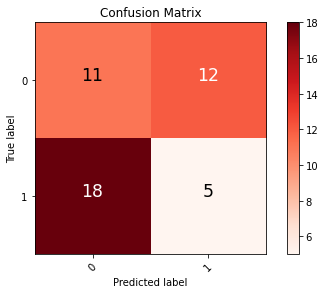

In [ ]:
#static files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []
splits = []
class_names = [0, 1]

split_no = 1

kfold = KFold(n_splits=n_splits, random_state=None, shuffle=True)

for train_index, test_index in kfold.split(static_nps):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_nps[train_index], static_nps[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #print graphs to see best parameter values
  #plot_graphs(history, 'accuracy')
  #plot_graphs(history, 'loss')

  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Train on 36 samples, validate on 10 samples
Epoch 1/25
 - 0s - loss: 1.0414 - accuracy: 0.3889 - val_loss: 0.7215 - val_accuracy: 0.4000
Epoch 2/25
 - 0s - loss: 0.7200 - accuracy: 0.7500 - val_loss: 0.7433 - val_accuracy: 0.4000
Epoch 3/25
 - 0s - loss: 0.7037 - accuracy: 0.5833 - val_loss: 0.7274 - val_accuracy: 0.4000
Epoch 4/25
 - 0s - loss: 0.6533 - accuracy: 0.5556 - val_loss: 1.1494 - val_accuracy: 0.4000
Epoch 5/25
 - 0s - loss: 0.5867 - accuracy: 0.7222 - val_loss: 1.0402 - val_accuracy: 0.2000
Epoch 6/25
 - 0s - loss: 0.6183 - accuracy: 0.6667 - val_loss: 0.7239 - val_accuracy: 0.5000
Epoch 7/25
 - 0s - loss: 0.4429 - accuracy: 0.8333 - val_loss: 1.5362 - val_accuracy: 0.1000
Epoch 8/25
 - 0s - loss: 0.2066 - accuracy: 0.9722 - val_loss: 1.6030 - val_accuracy: 0.3000
Epoch 9/25
 - 0s - loss: 0.2530 - accuracy: 0.9167 - val_loss: 3.5249 - val_accuracy: 0.4000
Epoch 10/25
 - 0s - loss: 0.2548 - accuracy: 0.9444 - val_loss: 2.9058 - val_accuracy: 0.2000
Epoch 11/25
 - 0s - loss:

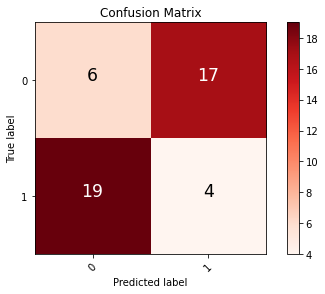

In [ ]:
#dyn files
n_epochs = 25
n_splits = 5
batch_size = 1
verbose = 2

accuracies = []
losses = []
trues = []
predicts = []
splits = []
class_names = [0, 1]

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(dyn_nps):
  #split data into X and y training and test sets
  static_X_train, static_X_test = dyn_nps[train_index], dyn_nps[test_index]
  static_y_train, static_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #print graphs to see best parameter values
  #plot_graphs(history, 'accuracy')
  #plot_graphs(history, 'loss')

  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)

  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob > 0.5) + 0

  trues.extend(y_true)
  predicts.extend(y_pred)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')